# Maximum likelihood ratio

We want to produce $N$ samples of the function 

$$\lambda(x_1,t,n) = 2x_1\log\left(\frac{n}{t}x_1\right) + 2(t-x_1)\log\left(\frac{n}{t}\frac{t-x_1}{n-1}\right)\quad,$$ 

where $x_1\sim P(\mu_s+\mu_b)$ is a Poison random deviate with mean $\mu_s+\mu_b$, and 

$$t = x_1 + \sum_{i=2}^{n} x_i\quad,$$ 

with $x_{i} \sim P(\mu_b)$ are Poison random deviates with mean $\mu_b$.

We start by coding the function above 

In [1]:
def lamb(x1,t,n):
    from numpy import log, maximum, logical_and, zeros_like
    good      =  logical_and(x1 > 0, t > 0)
    xg,tg     =  x1[good], t[good]
    return 2*xg*log(n/tg*xg)+2*(tg-xg)*log(n/tg*(tg-xg)/(n-1)) 

Next, we want to generate the $\lambda$ samples for different values of $\mu_s,\mu_b$, so we code up a function that will return a sample of $\lambda$

In [2]:
def sample_lamb(mus,mub,n=100,size=10000):
    from numpy.random import poisson 
    
    x1 = 1.*poisson(mus+mub,size=size)
    t  = x1 + poisson(mub,size=(size,n-1)).sum(axis=1)
    return lamb(x1,t,n)

Let us plot samples of $10\,000$ with $\mu_b=0.1,10,1\,000$ and $\mu_s=1$. 

In [3]:
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats
import scipy.special

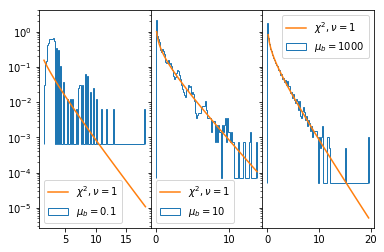

In [4]:
fig, ax = plt.subplots(ncols=3,sharey=True,
                       gridspec_kw=dict(wspace=0))
for a,mub in zip(ax,[0.1,10,1000]):
    s     = sample_lamb(0,mub)
    h,b,_ = a.hist(s,100,histtype='step',density=True,
                 label=fr'$\mu_b={mub}$',log=True)
    chiy = sp.stats.chi2.pdf(b,1)
    a.plot(b,chiy,label=r'$\chi^2,\nu=1$')
    a.legend()

And now for fixed $\mu_b=1000$, and $\mu_s=100,200$. 

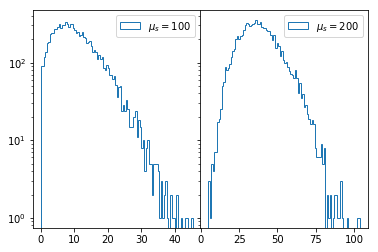

In [5]:
fig, ax = plt.subplots(ncols=2,sharey=True,
                       gridspec_kw=dict(wspace=0))
for a,mus in zip(ax,[100,200]):
    h,b,_ = a.hist(sample_lamb(mus,1000),100,histtype='step',
                 label=fr'$\mu_s={mus}$')
    a.set_yscale('log')
    a.legend()

# Spherical distributions

We will look at spherical distributions.  This is particularly relevant if one is studying, for example, the _cosmic microwave background_ (CMB).

From astronomy we have the package [_healpy_](https://healpy.readthedocs.io) - which is a specialised package for doing spherical projections and the like  

In [6]:
import healpy as hp

We will define some spherical distribution.   For an _isotropic_ distribution we will choose 

$$\phi \sim U(0,2\pi)\quad \cos\theta \sim U(-1,1)\quad,$$ 

that is, we choose the azimuthal angle $\phi$ uniformly over $[0,2\pi]$, and the _cosine_ of the polar angle $\theta$ uniformly over $[-1,1]$.  We chose the polar angle in this way to make the distribution even per unit surface on the sphere. 

We encode these into functions. 

In [7]:
def flat_phi(size):
    from numpy import pi 
    from numpy.random import uniform 
    
    return uniform(0,2*pi,size=size)

In [8]:
def isotropic_theta(size):
    from numpy.random import uniform
    from numpy import arccos 
    
    return arccos(uniform(-1,1,size=size))

To sample dipole distributions, we select $\theta$ by 

$$\cos\theta = \frac{1}{a}\left(1-\sqrt{1+2a+a^2-4at}\right)\quad\text{width}\quad t\sim U(0,1)\quad,$$

where $a$ is the asymmetry of the dipoles.  For the azimuthal angle $\phi$ we do as above - that is 

$$\phi \sim U(0,2\pi)\quad.$$

In [9]:
def dipole_theta(a,size):
    from numpy import sqrt, arccos
    from numpy.random import uniform
    
    return arccos((1-sqrt(1+2*a+a**2-4*a*uniform(size=size)))/a)

Let us make two functions to generate samples of either isotropic or dipole distributions 

In [10]:
def pairup(theta,phi):
    from numpy import concatenate
    
    return concatenate((theta,phi)).reshape(2,*theta.shape).T

def isotropic(size):
    return pairup(isotropic_theta(size),flat_phi(size))

def dipole(size,a=.9):
    return pairup(dipole_theta(a,size),flat_phi(size))

Let us plot some distributions 

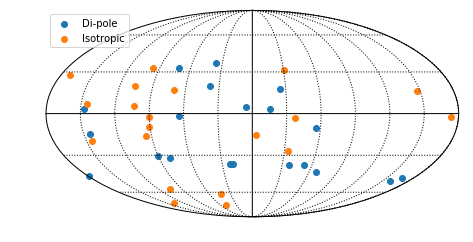

In [11]:
nt  = 20
dip = dipole(nt)
iso = isotropic(nt)
hp.graticule(verbose=False)
hp.projscatter(*dip.T,color='C0',label='Di-pole')
hp.projscatter(*iso.T,color='C1',label='Isotropic')
plt.legend();

# Cumulative pair-correlation function 

Next, we want to calculate the pair-wise cumulative correlation.  Our points above a distributed on the unit-sphere, meaning for any point $\vec{v}_i$, we have 

$$|\vec{v}_i|=1\quad i=1,\ldots,n\quad,$$

and it follows that the angle between any two points is given by 

$$\cos\theta_{ij} = \vec{v}_i\cdot\vec{v}_j\quad,$$ 

and thus we define the cumulative two-point correlation function as 

$$\mathcal{C}\left(\{\vec{v}_i\},\phi\right) 
= \frac{2}{n(n-1)}\sum_{i=1}^{n}\sum_{j=1}^{i-1}\Theta(\cos\phi_{ij}-\cos\phi)\quad,$$ 

with 

$$\Theta(x) = \begin{cases} 1 & x\ge 0\\ 0 &x<0\end{cases}\quad.$$ 

Thus, we need to calculate the lower triangle matrix 

$$T_{ij} = \vec{v}_i\cdot \vec{v}_j\quad,$$ 

and sum the cosine of that over each row.   We do this by binning the above elements $T_{ij}$, and then calculate the cumulative probability function.   But first, we need a function to transform the spherical polar coordinates into Cartisian coordinates to take the inner product. 

In [12]:
def sphere2box(rho,theta,phi):
    from numpy import cos, sin, array
    return array([rho * cos(phi) * sin(theta),
                  rho * sin(phi) * sin(theta),
                  rho * cos(theta)])

Thus, we first transform the spherical coordinates to Cartisian coordinates, calculate the inner product $T_{ij}$ of all pairs, take out the lower triangle, and bin these in fine bins.  Next, we calculate the cumulative sum and normalize to get $\mathcal{C}+1$.  The function will return $\mathcal{C}\left(\{\vec{v},\cos\phi\right)$ and the $\cos\phi$'s where we evaluated $\mathcal{C}$.  

In [13]:
def cdf_pairs(theta,phi,nbins=1000,rho=1,dof=-1):
    from numpy import linspace, tril_indices_from, histogram
    
    b   = sphere2box(rho,theta,phi)
    c   = b.T.dot(b)
    t   = c[tril_indices_from(c,dof)]
    b   = linspace(-1,1,nbins)
    x   = (b[1:]+b[:-1])/2
    p,_ = histogram(t,b)
    d   = 1-p.cumsum()/len(t)
    return x,d

For an isotropic distribution the expectation of 

$$E\left[\mathcal{C}(\phi)\right] = \frac12\left(1-\cos\phi\right)\quad.$$ 

We plot $\mathcal{C}$ evaluated over the two samples above, as well as the expectation for an isotropic distribution. 

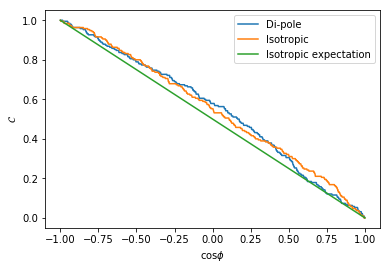

In [14]:
cost, dip_cdf = cdf_pairs(*dip.T)
_,    iso_cdf = cdf_pairs(*iso.T)
plt.plot(cost,dip_cdf,label='Di-pole')
plt.plot(cost,iso_cdf,label='Isotropic')
plt.plot(cost,(1-cost)/2,label='Isotropic expectation')
plt.xlabel(r'$\cos\phi$')
plt.ylabel(r'$\mathcal{C}$')
plt.legend();

**Note** Normally a CDF _increases monotonically_ over the domain from 0 to 1, as it is the integral 

$$F(x) = \int_{a}^{x} dx'\,f(x')\quad,$$ 

where $f$ is the probability density function (PDF) and $a$ (possibly $-\infty$) is the lower bound of the domain of the PDF.  However, here the cumulative pair-wise correlation function is defined differently and thus _decreases monotonically_ over the domain.

To test if two observed distributions are the same, we can employ a Kolmogorov-Smirnov (KS) test.  Suppose we have two _cumulative_ distributions $0 \le F(x) \le 1$ and $0 \le G(x) \le 1$ over the same domain.  Then we define the KS test statistics as  

$$t = \sup_x |F(x)-G(x)|\quad,$$ 

that is, the maximum distance between the two distributions.  We define a function to calculate the KS-$t$ and returns $t$, as well as the $x$ where that occurs. 

In [15]:
def kftest(f,g):
    from numpy import abs, argmax
    
    d = abs(f-g)
    i = argmax(d)
    return d[i], i

Let us redo the samples and recalculate the cumulative pair distributions to evaluate the KS-$t$.  We plot the cumulative distributions but also the KS-$t$ against the expectation for an isotropic distribution for both samples. 

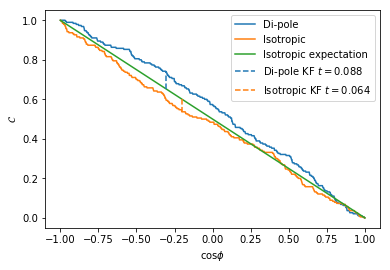

In [16]:
nt            = 20
dip           = dipole(nt)
iso           = isotropic(nt)
cost, dip_cdf = cdf_pairs(*dip.T)
_,    iso_cdf = cdf_pairs(*iso.T)
iso_exp       = (1-cost)/2
dip_t,dip_it  = kftest(dip_cdf,iso_exp)
iso_t,iso_it  = kftest(iso_cdf,iso_exp)

plt.plot(cost,dip_cdf,label='Di-pole')
plt.plot(cost,iso_cdf,label='Isotropic')
plt.plot(cost,(1-cost)/2,label='Isotropic expectation')

plt.plot([cost[dip_it]]*2,
         [iso_exp[dip_it],dip_cdf[dip_it]],
         '--',color='C0',
         label=fr'Di-pole KF $t={dip_t:.3f}$')
plt.plot([cost[iso_it]]*2,
         [iso_exp[iso_it],iso_cdf[iso_it]],
         '--',color='C1',
         label=fr'Isotropic KF $t={iso_t:.3f}$')
         

plt.xlabel(r'$\cos\phi$')
plt.ylabel(r'$\mathcal{C}$')
plt.legend();

# Spherical harmonics 

The [spherical harmonics](https://en.wikipedia.org/wiki/Spherical_harmonics) 

$$Y_{l}^{m}(\theta,\phi )=Ne^{im\phi }P_{l}^{m}(\cos{\theta })\quad m=-l,\ldots l\quad,$$

where $P_{\ell}$ is the Legendre polynomials and $N$ some normalisation, are to functions defined on a sphere as the Fourier harmonics 

$$ f_n(x) = e{-inx}\quad,$$ 

are to functions defined on the interval $[-\pi,\pi]$: $Y_{\ell}^{m}$ form a orthonormal set spanning a subspace of functions 

$$\{f\,|\,f:\theta,\phi\mapsto\mathbb{R},\,\theta\in[-\pi,\pi],\,\phi\in[0,2\pi]\}\quad.$$

That is, for most practical applications we can decompose the spherical distributions in terms of spherical harmonics.  Thus, if we have a spherical problem (such as the CMB) then we can use spherical harmonics as a first approach to understand the problem.  

Let us plot some spherical harmonics

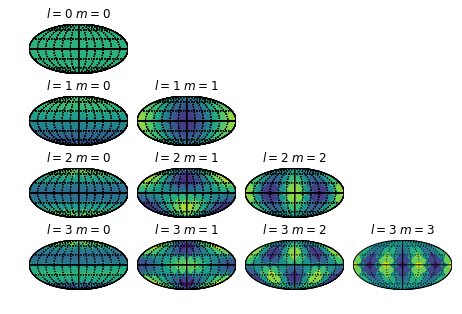

In [17]:
def ylm_map(l,m,lmax=4*128):
    from numpy import zeros, complex 
    from healpy.sphtfunc import Alm
    from healpy import alm2map, graticule, mollview
    
    
    size     = (lmax+2)*(lmax+1)//2
    alm      = zeros(size,dtype=complex)
    idx      = Alm.getidx(lmax,l,m)
    alm[idx] = 1  # 1j
    ylm      = alm2map(alm,lmax//4,lmax=lmax,verbose=False)
    return ylm 

def plot_ylms(lmax):
    from matplotlib.pyplot import figure 
    from numpy import tril_indices
    from healpy import mollview, graticule
    
    fig = figure()
    
    for l,m in zip(*tril_indices(lmax+1)):
        mylm = ylm_map(l,m,4*lmax)
        idx  = (l*(lmax+1)+m+1)
        mollview(mylm,fig,sub=(lmax+1,lmax+1,idx),
                 title=fr'$l={l}\ m={m}$',cbar=False,min=-1,max=1)
        graticule(verbose=False)
        
plot_ylms(3)

# Power spectrum 

The power spectrum of a spherical function is defined via the Fourier decomposition of the function in terms of spherical harmonics 

$$g(\theta,\phi) = \sum_{l=0}^{\infty}\sum_{m=-l}^{l}a_{lm}Y_l^m(\theta,\phi)\quad,$$ 

where the coefficients are 

$$a_{lm} = \int\mathrm{d}\Omega\,{Y_{l}^{m}}^{\dagger}(\theta,\phi)g(\theta,\phi)\quad.$$

The power spectrum then becomes 

$$C_{l} = \frac{1}{2l+1}\sum_{m=-l}^{l}|a_{lm}|^2\quad,$$ 

and reflects the symmetry of the function at different angular scales.  That is, small $l$ corresponds to large angular scales, while large $l$ corresponds to small angular scales.   

In particular, we are interested in the distribution of  

$$t=\frac{C_1}{C_0}$$ 

since $C_i\approx 0, i>1$ corresponds to an isotropic distribution, and thus $t$ allows us to test in a given distribution is isotropic or not. However, we will evaluate $t$ over many different maps, and the median of the distribution is used as the measure. 

First, we define a function to analyse a given sample to extract $t$.  This is rather simple.  We histogram the observations of each $(\theta,\phi)$ coordinate - translated to pixel coordinates - to get $g(\theta,\phi)$, then use the function `healpy.anafast` to get the powerspectrum and then calculate $t=C_1/C_0$. 

In [18]:
def clana(m,lmax):
    from healpy import anafast 
    
    cls = anafast(m,alm=True,lmax=lmax)
    return cls[0]/cls[0][0]

In [19]:
def ana(px,npix,lmax):
    from numpy import histogram
    
    h, _ =  histogram(px,npix)
    h    =  h / len(px)
    return clana(h,lmax)[1]

Next, we define a function to analyse $N$ samples.  We calculate the pixel coordinates from the sample $\theta,\phi$ coordinates and pass those for each sample to the function above.  This allows us to analyse a large number of samples very quickly (the bottle-neck in all of this is `healpy.anafast`). 

In [20]:
def nana(nside,sample,lmax=30):
    from healpy import nside2npix, ang2pix 
    from numpy import array
    
    npix = nside2npix(nside)
    pxs  = ang2pix(nside,sample[...,0],sample[...,1])
    
    return array([ana(px,npix,lmax) for px in pxs])

Let us generate $10\,000$ tests of each $100$ $\theta,\phi$-pairs.  We make to such samples - one for the dipole distribution and one for the isotropic distribution.   We then obtain the test statistics for each of the tests for each distribution. 

In [21]:
nt    = (100,10000)
nside = 20
dip   = dipole(nt)
iso   = isotropic(nt)
dip_t = nana(nside,dip)
iso_t = nana(nside,iso)

Let us plot the distribution of $t$ for each sample kind, as well as the median of each of the $t$ distributions. 

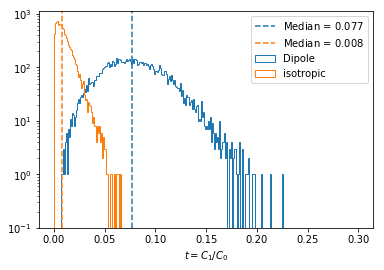

In [22]:
def draw_clt(dip_t,iso_t):
    from numpy import linspace, median
    from matplotlib.pyplot import hist,axvline,xlabel,legend

    bins = linspace(0,.3,301)
    opts = dict(bins=bins,density=False,log=True,histtype='step')
    hist(dip_t,**opts,label='Dipole')
    hist(iso_t,**opts,label='isotropic')

    mdip = median(dip_t)
    miso = median(iso_t)

    axvline(mdip,ls='--',color='C0',label=fr'Median = ${mdip:.3f}$')
    axvline(miso,ls='--',color='C1',label=fr'Median = ${miso:.3f}$')
    xlabel(r'$t=C_1/C_0$')

    legend()
    
draw_clt(dip_t,iso_t)

We see a large difference between the two samples - the isotropic has a very low median value of $t$ relative to the dipole sample. 

# Sky-map data 

We investigate data.  We have two samples 

- A true measurement `truemap1.fit`.  
- A template map generated from the mean of the above map `eventmap1.fit`. 

We want to determine the the normalised power-spectrum

$$ C_l/C_0\quad,$$ 

for each sample.  We write a simple function that reads in the data, visualise and calculate the power-spectrum up to $l_{\mathrm{max}}$ using the _healpy_ `anafast` function.   

In [23]:
def anafile(filename,fig,sub,lmax=40,title=''):
    from healpy import read_map,anafast,mollview,graticule
    
    m,h  = read_map(filename,h=True,verbose=False)
    d = {k.lower():v for k,v in h}
    
    mollview(m,fig=fig,sub=sub,title=title)
    graticule(verbose=False)
    
    return m, d, clana(m,lmax)

We read in the two data files and get the maps and power-spectra.  We get the number of pixels in each dimension from the header of the data. 

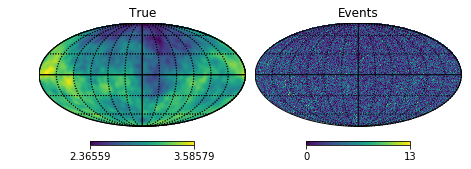

In [24]:
fig = plt.figure()
lmax = 40

mt,ht,clt = anafile('truemap1.fits',fig,(1,2,1), lmax,'True')
me,he,cle = anafile('eventmap1.fits',fig,(1,2,2),lmax,'Events')
npix     = hp.nside2npix(he['nside'])

We want to estimate the noise level in the measurements.  For some number $N$ of simulations, we do 

- scramble the map by interchanging $n$ random pixels. 
- Calculate the normalised power-spectrum 

Then, we estimate the noise level by the median of the $N$ simulations and the $90\%$ confidence limits from the $5\%$ and $95\%$ percentiles of the normalised power-spectra.   This is _similar_ to a [boot-strap](https://cholmcc.gitlab.io/nbi-python/statistics/#Bootstrap) method of estimating the variance of an estimator, and as such will tend to _overestimate_ the uncertainties.

First, we make a function that shuffles the data around.  We take advantage of the indecing functionality of _NumPy_ to do this effectively.  Note, we _copy_ the map before swapping pixels - least we do not mutate the original map.  

In [25]:
def scrample(m,n):
    from numpy import array
    from numpy.random import randint, shuffle
    
    i, j = randint(len(m),size=(2,n))
    c    = m.copy()
    c[i],c[j] = c[j],c[i]
    # shuffle(c)
    
    return c 

Then, we write a function that generates $N$ scrambled maps, performs the analysis for the normalised power-spectrum of each up to some $l_{\mathrm{max}}$, and then calculates the percentiles of the $N$ spectra. 

In [26]:
def bg(m,n,N,lmax):
    from numpy import array, percentile 
    
    samples = array([clana(scrample(m,n),lmax) for _ in range(N)])
    return array([percentile(samples,p,axis=0) for p in (5,50,95)]),samples

Let us get the noise estimates and percentile by applying the procedure above to the generated Poisson map.  We generate 1000 samples and we shuffle 2 times the number of pixels in the map. 

In [27]:
bgcl,s = bg(me,2*npix,1000,lmax)

We can now plot the measured, Poisson, and noise power-spectra. 

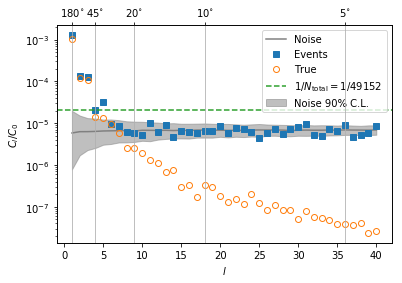

In [28]:
import numpy as np

ls = np.arange(1,lmax+1)
plt.fill_between(ls,bgcl[0][1:],bgcl[2][1:],
                 color='gray',alpha=.5,
                 label='Noise 90% C.L.')
plt.plot(ls,bgcl[1][1:],color='gray',
         label='Noise')
plt.plot(ls,cle[1:],'s',label='Events')
plt.plot(ls,clt[1:],'o',label='True',markerfacecolor='none')
plt.axhline(1/npix,ls='--',color='C2',
            label=fr'$1/N_{{\mathrm{{total}}}}=1/{npix}$')
plt.yscale('log')
plt.ylabel(r'$C_l/C_0$')
plt.xlabel(r'$l$')

bax   = plt.gca()
tax   = bax.twiny()
tax.grid()
tax.set_xlim(bax.get_xlim())
dtick = np.array([1,4,9,18,36])
tax.set_xticks(dtick)
tax.set_xticklabels([fr'${180/l:.0f}^{{\circ}}$' for l in dtick])

bax.legend();